In [43]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
from datetime import date
import re
import torch
import matplotlib.pyplot as plt
from pacmap import PaCMAP
torch.device('cpu')

device(type='cpu')

In [2]:
queries_of_interest = ['computer science', 'computational biology']

In [3]:
import arxiv
search = arxiv.Search(
  query = "computer science",
  max_results = 2,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

for result in search.results():
    print(result.categories)

['cs.CV', 'cs.AI', 'cs.LG']
['cs.CL', 'cs.LG']


In [20]:
def get_data(query,max_results):
    search = arxiv.Search(
      query = query,
      max_results = max_results,
      sort_by = arxiv.SortCriterion.SubmittedDate
    )
    
    paper_data = []
    
    for result in search.results():
        category_vector = [result.categories[i] if i<len(result.categories) else "Nafin" for i in range(3)]
        
        
        abstract = result.summary.replace('\n',' ').replace('\\&','').replace('\\%','')
        
        re.sub()
        temp = [result.title,result.published,abstract,result.pdf_url]
        temp.extend(category_vector)
        paper_data.append(temp)
        
    df = pd.DataFrame(data=paper_data, columns=['Title','Date', 'Abstract',"PDF URL",'Category1','Category2','Category3'])
    
    return df

In [18]:
get_data("computer science",100)

,Title,Date,Abstract,PDF URL,Category1,Category2,Category3
0,What Makes for Hierarchical Vision Transformer?,2021-07-05 17:59:35+00:00,Recent studies show that hierarchical Vision T...,http://arxiv.org/pdf/2107.02174v1,cs.CV,cs.AI,cs.LG
1,Is Automated Topic Model Evaluation Broken?: T...,2021-07-05 17:58:52+00:00,"Topic model evaluation, like evaluation of oth...",http://arxiv.org/pdf/2107.02173v1,cs.CL,cs.LG,Nafin
2,On Model Calibration for Long-Tailed Object De...,2021-07-05 17:57:20+00:00,Vanilla models for object detection and instan...,http://arxiv.org/pdf/2107.02170v1,cs.CV,cs.AI,cs.LG
3,Ionisation potentials and electron affinity of...,2021-07-05 17:46:20+00:00,We present high accuracy relativistic coupled ...,http://arxiv.org/pdf/2107.02164v1,physics.atom-ph,Nafin,Nafin
4,Depth-efficient proofs of quantumness,2021-07-05 17:45:41+00:00,A proof of quantumness is a type of challenge-...,http://arxiv.org/pdf/2107.02163v1,quant-ph,Nafin,Nafin
...,...,...,...,...,...,...,...
95,2D hybrid CrCl2(N2C4H4)2 with tunable ferromag...,2021-07-05 08:32:29+00:00,Two-dimensional ferromagnetic (2D FM) half-met...,http://arxiv.org/pdf/2107.01862v1,cond-mat.mtrl-sci,cond-mat.str-el,Nafin
96,Optimal metrology with variational quantum cir...,2021-07-05 08:30:12+00:00,Cold atoms and ions exhibit unparalleled perfo...,http://arxiv.org/pdf/2107.01860v1,quant-ph,physics.atom-ph,Nafin
97,Automating Generative Deep Learning for Artist...,2021-07-05 08:26:50+00:00,We present a framework for automating generati...,http://arxiv.org/pdf/2107.01858v1,cs.LG,Nafin,Nafin
98,A theoretical analysis of one-dimensional disc...,2021-07-05 08:17:50+00:00,Despite the widespread usage of discrete gener...,http://arxiv.org/pdf/2107.01855v1,math.PR,Nafin,Nafin


In [6]:
from transformers import AutoTokenizer, AutoModel

#Mean Pooling - Take attention mask into account for correct averaging



# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub


# Tokenize sentences


# Perform pooling. In this case, max pooling.


print("Sentence embeddings:")
print(sentence_embeddings)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentence embeddings:
tensor([[-0.3931,  0.0389,  1.9874,  ..., -0.6094, -1.0946,  0.3265],
        [ 0.0615,  0.3274,  1.8332,  ..., -0.1299,  0.4609,  0.2404]])


In [7]:
sentence_embeddings.shape

torch.Size([2, 768])

In [30]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embeddings(df):
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
    model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
    
    abstracts = df.Abstract.values
    abstracts = [str(a) for a in abstracts]
    
    encoded_input = tokenizer(abstracts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embeddings.numpy()

In [40]:
data = get_data("computer science",100)

In [41]:
embeddings = get_embeddings(data)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [42]:
embeddings.shape

(100, 768)

In [44]:
result = PaCMAP().fit_transform(embeddings)

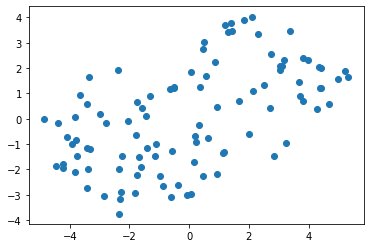

In [45]:
plt.scatter(result[:,0],result[:,1])

In [37]:
from sklearn.neighbors import KNeighborsTransformer

In [38]:
knt = KNeighborsTransformer(n_neighbors=3)
knt.fit(result)
A = knt.kneighbors_graph(result)

In [39]:
A[0]

<1x100 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [46]:
from IPython.display import clear_output

def make_training_data(data):
    i = 0
    y_vals = np.full(data.shape[0],-1)
    for i in range(data.shape[0]):
        print(data['Title'].values[i])
        print()
        print(data['Abstract'].values[i])
        val = input("Would you read this (1-Yes, 0-No, -1-Exit)")
        if val == "-1":
            break
        y_vals[i] = float(val)
        clear_output()
    return y_vals

In [47]:
make_training_data(data)

Enhanced prediction for discrete-time input-delayed systems with unknown disturbances

This paper deals with the problem of predicting the future state of discrete-time input-delayed systems in the presence of unknown disturbances that can affect both the input and the output equations of the plant. Since the disturbance is unknown, an exact prediction of the plant states is not feasible. We propose the use of a high-order extended Luenberger-type observer for the plant states, disturbances, and their finite difference variables. Then, a new method for computation of the prediction is proposed which, under certain assumptions, allows for enhanced prediction and consequently improved attenuation of the unknown disturbances. Detailed analysis of the performance of the proposed scheme is carried out, while linear matrix inequalities (LMIs) are used for the observer design in order to mitigate the prediction errors.
Would you read this (1-Yes, 0-No, -1-Exit)-1


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [48]:
col = [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

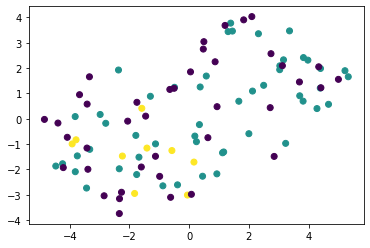

In [49]:
plt.scatter(result[:,0],result[:,1],c=col)

In [66]:
def show_closest_papers(df,embeddings,neighbors):
    titles,abstracts = df.Title.values, df.Abstract.values
    knt = KNeighborsTransformer(n_neighbors=neighbors)
    knt.fit(embeddings)
    A = knt.kneighbors_graph(embeddings).toarray()
    
    
    for i in range(df.shape[0]):
        print("Paper to compare: ", titles[i])
        print()
        print(abstracts[i])
        
        print()
        
        print("Other Papers: ")
        print()
        
        v = A[i]
        close_titles = data.Title.values[(v==1)]
        print(close_titles)
        
        val = input("Would you read this (-1-Exit)")
        if val == "-1":
            break

        clear_output()

In [ ]:
show_closest_papers(data,embeddings,5)

Paper to compare:  Do Different Tracking Tasks Require Different Appearance Models?

Tracking objects of interest in a video is one of the most popular and widely applicable problems in computer vision. However, with the years, a Cambrian explosion of use cases and benchmarks has fragmented the problem in a multitude of different experimental setups. As a consequence, the literature has fragmented too, and now the novel approaches proposed by the community are usually specialised to fit only one specific setup. To understand to what extent this specialisation is actually necessary, in this work we present UniTrack, a unified tracking solution to address five different tasks within the same framework. UniTrack consists of a single and task-agnostic appearance model, which can be learned in a supervised or self-supervised fashion, and multiple "heads" to address individual tasks and that do not require training. We show how most tracking tasks can be solved within this framework, and tha